In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import xgboost as xgb
from datetime import datetime
%matplotlib inline
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = [16,10]

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [4]:
train.describe(include='all')

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
count,1458644,1458644.000,1458644,1458644,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644,1458644.000
unique,1458644,nan,1380222,1380377,nan,nan,nan,nan,nan,2,nan
top,id3489035,nan,2016-01-12 18:48:44,2016-02-19 19:25:04,nan,nan,nan,nan,nan,N,nan
freq,1,nan,5,5,nan,nan,nan,nan,nan,1450599,nan
mean,NaN,1.535,NaN,NaN,1.665,-73.973,40.751,-73.973,40.752,NaN,959.492
std,NaN,0.499,NaN,NaN,1.314,0.071,0.033,0.071,0.036,NaN,5237.432
min,NaN,1.000,NaN,NaN,0.000,-121.933,34.360,-121.933,32.181,NaN,1.000
25%,NaN,1.000,NaN,NaN,1.000,-73.992,40.737,-73.991,40.736,NaN,397.000
50%,NaN,2.000,NaN,NaN,1.000,-73.982,40.754,-73.980,40.755,NaN,662.000
75%,NaN,2.000,NaN,NaN,2.000,-73.967,40.768,-73.963,40.770,NaN,1075.000


In [5]:
#Removing the outliers in trip_duration as it contains a max of 980 hours and min of 1 sec which is not possible(almost 2.4k records)
#excluding the data outside of 2 standard deviations
#check about 4 std
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m+2*s]
train = train[train['trip_duration'] >= m-2*s]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456540 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1456540 non-null object
vendor_id             1456540 non-null int64
pickup_datetime       1456540 non-null object
dropoff_datetime      1456540 non-null object
passenger_count       1456540 non-null int64
pickup_longitude      1456540 non-null float64
pickup_latitude       1456540 non-null float64
dropoff_longitude     1456540 non-null float64
dropoff_latitude      1456540 non-null float64
store_and_fwd_flag    1456540 non-null object
trip_duration         1456540 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 133.4+ MB


In [6]:
#ny city's long and lats border are - 
# city_long_border = (-74.03, -73.75)
# city_lat_border = (40.63, 40.85) 
#limiting the records to this space

train = train[train['pickup_longitude'] <=-73.35]
train = train[train['pickup_longitude'] >=-74.03]
train = train[train['pickup_latitude'] <=40.85]
train = train[train['pickup_latitude'] >=40.63]

train = train[train['dropoff_longitude'] <=-73.35]
train = train[train['dropoff_longitude'] >=-74.03]
train = train[train['dropoff_latitude'] <=40.85]
train = train[train['dropoff_latitude'] >=40.63]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1438576 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1438576 non-null object
vendor_id             1438576 non-null int64
pickup_datetime       1438576 non-null object
dropoff_datetime      1438576 non-null object
passenger_count       1438576 non-null int64
pickup_longitude      1438576 non-null float64
pickup_latitude       1438576 non-null float64
dropoff_longitude     1438576 non-null float64
dropoff_latitude      1438576 non-null float64
store_and_fwd_flag    1438576 non-null object
trip_duration         1438576 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 131.7+ MB


In [7]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

In [8]:
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime) #Not in Test

In [9]:
train['trip_duration'].values

array([ 455,  663, 2124, ...,  764,  373,  198], dtype=int64)

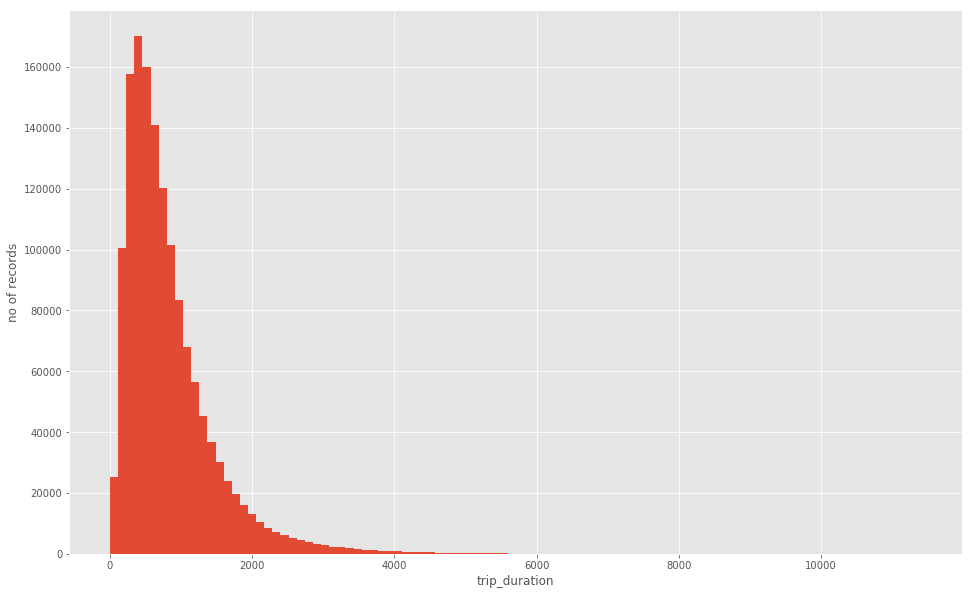

In [10]:
plt.hist(train['trip_duration'].values,bins=100)
plt.xlabel('trip_duration')
plt.ylabel('no of records')
plt.show()

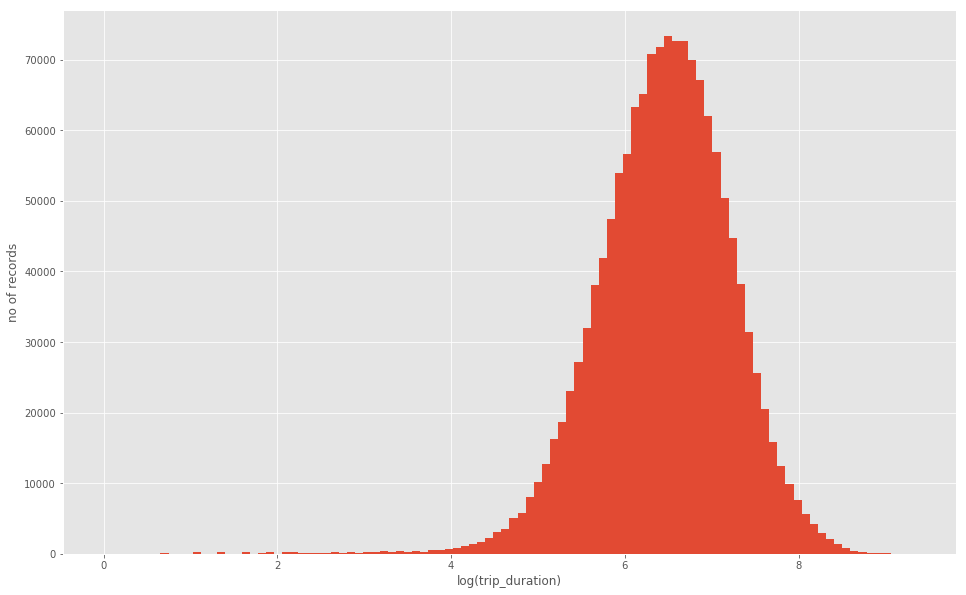

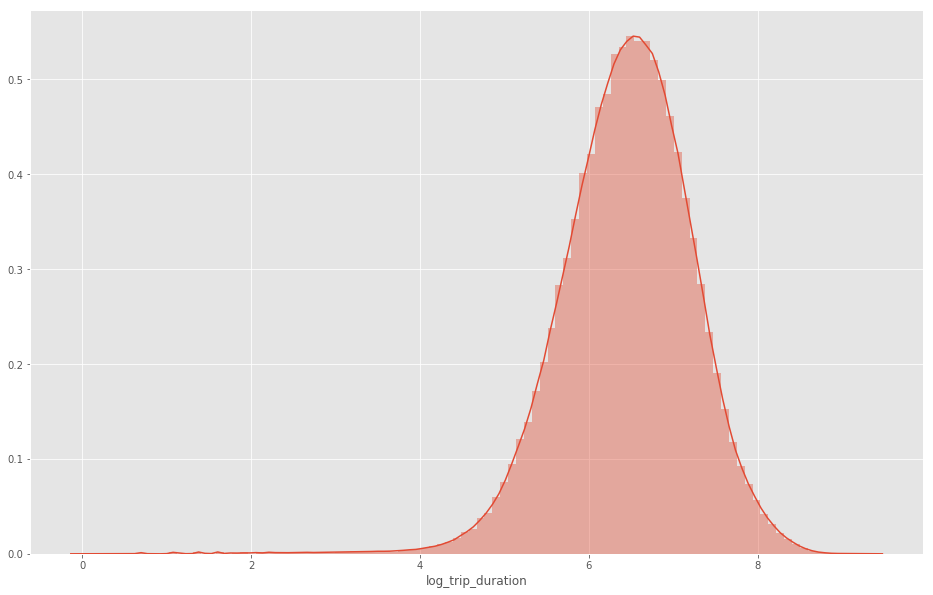

In [11]:
#Lets try log transformation as the upper graph is posotive skewed.
train['log_trip_duration'] = np.log(train['trip_duration'].values)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel("log(trip_duration)")
plt.ylabel("no of records")
plt.show()
sns.distplot(train['log_trip_duration'],bins=100)

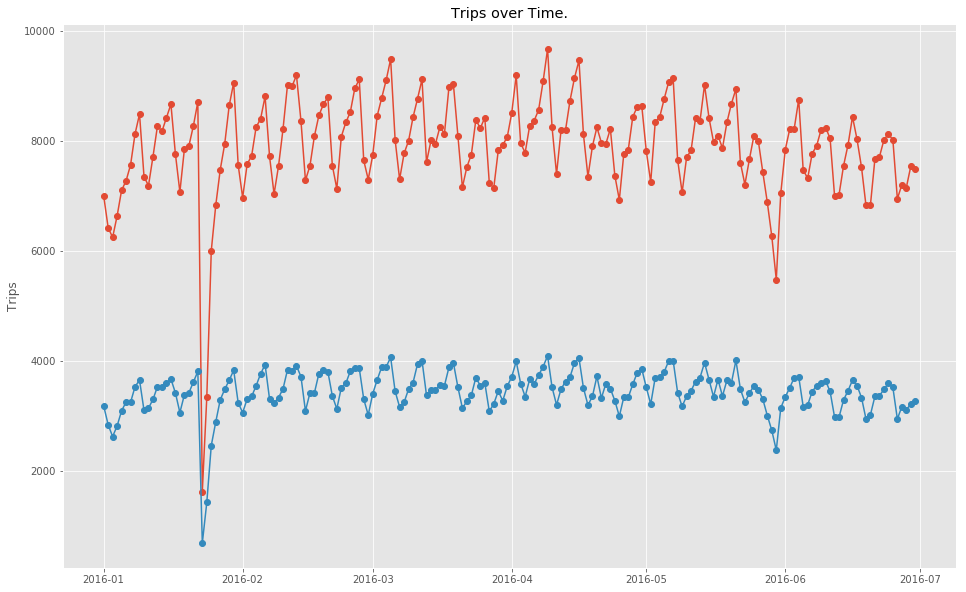

In [12]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Trips over Time.')
#plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

In [13]:
#lets check about vendors
plot_vendor = train.groupby('vendor_id')['trip_duration'].mean()

(800.0, 840)

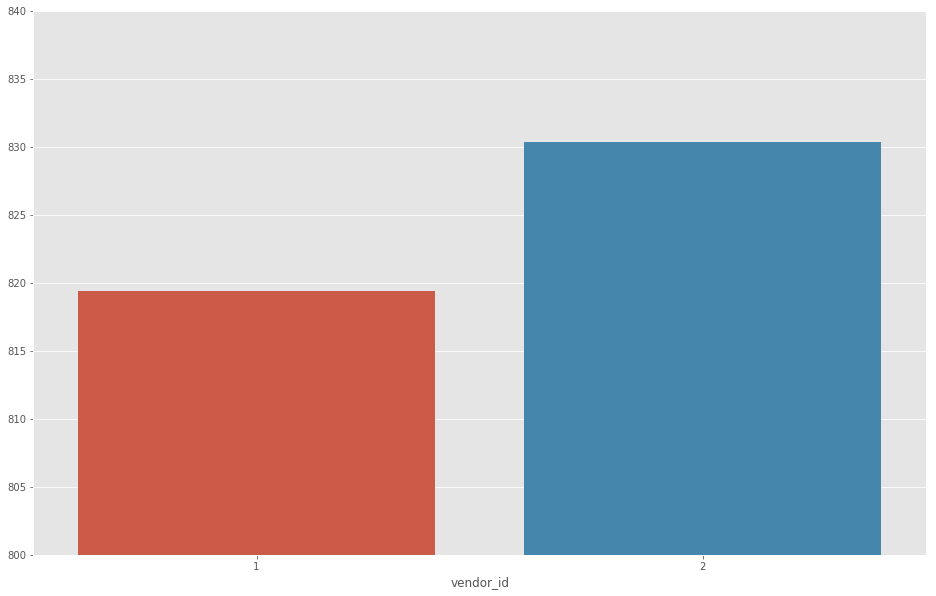

In [14]:
sns.barplot(plot_vendor.index,plot_vendor.values)
plt.ylim(ymin=800)
plt.ylim(ymax=840)

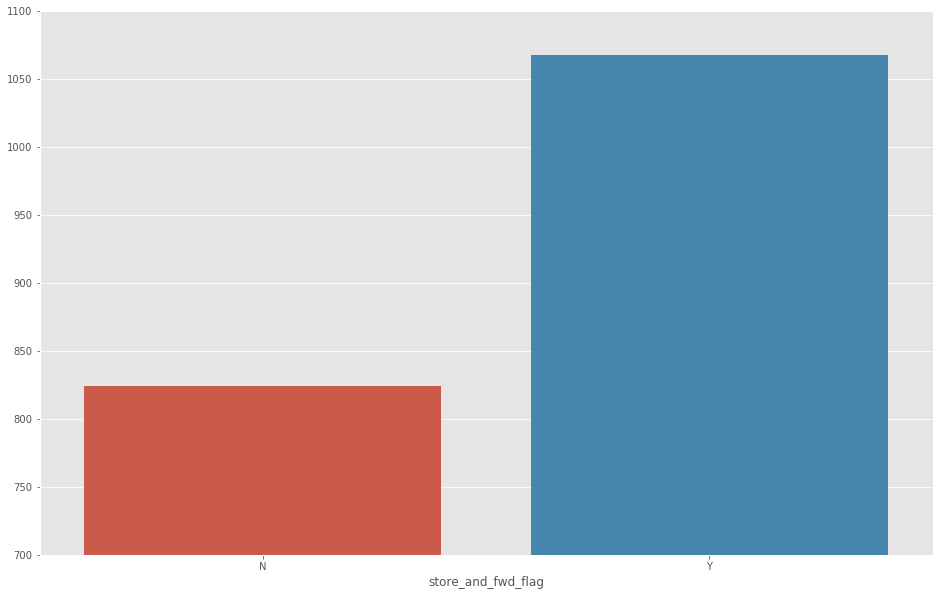

In [15]:
#not much of a difference
snwflag = train.groupby('store_and_fwd_flag')['trip_duration'].mean()
plt.ylim(ymin=700)
plt.ylim(ymax=1100)
sns.barplot(snwflag.index,snwflag.values)

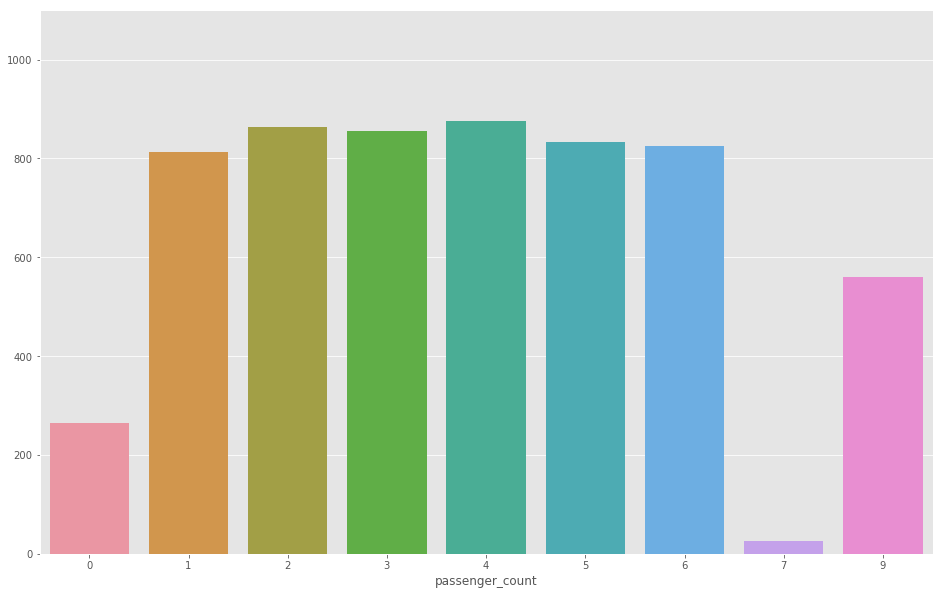

In [16]:
pc = train.groupby('passenger_count')['trip_duration'].mean()
plt.ylim(ymax=1100)
plt.ylim(ymin=0)
sns.barplot(pc.index,pc.values)

In [17]:
train.groupby('passenger_count').size()

passenger_count
0         52
1    1019764
2     207072
3      59036
4      27989
5      76980
6      47681
7          1
9          1
dtype: int64

In [18]:
test.groupby('passenger_count').size()

passenger_count
0        23
1    443447
2     90027
3     25686
4     12017
5     33411
6     20521
9         2
dtype: int64

In [19]:
city_long_border = (-74.03,-73.75)
city_lat_border = (40.63,40.85)

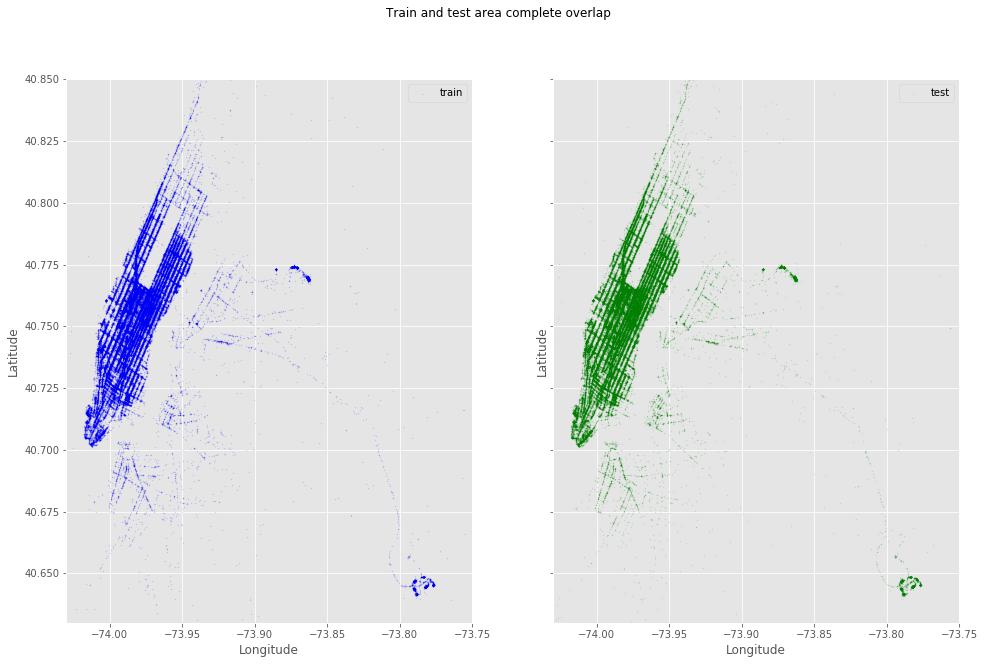

In [20]:
plt.figure()
fig, ax = plt.subplots(ncols=2, sharex=True,sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000], color='blue',s=1,alpha=0.1,label='train')
ax[1].scatter(test['pickup_longitude'].values[:100000], test['pickup_latitude'].values[:100000],color='green',s=1,alpha=0.1,label='test')
fig.suptitle("Train and test area complete overlap")
ax[0].legend(loc=0)
ax[1].legend(loc=1)
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.show()

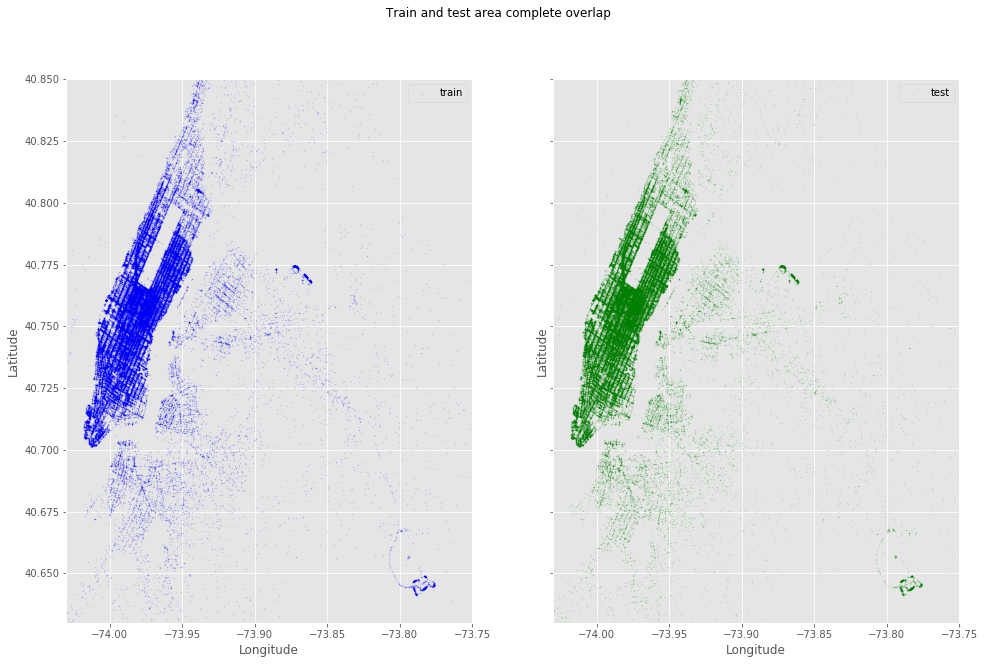

In [21]:
plt.figure()
fig, ax = plt.subplots(ncols=2, sharex=True,sharey=True)
ax[0].scatter(train['dropoff_longitude'].values[:100000], train['dropoff_latitude'].values[:100000], color='blue',s=1,alpha=0.1,label='train')
ax[1].scatter(test['dropoff_longitude'].values[:100000], test['dropoff_latitude'].values[:100000],color='green',s=1,alpha=0.1,label='test')
fig.suptitle("Train and test area complete overlap")
ax[0].legend(loc=0)
ax[1].legend(loc=1)
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.show()

In [22]:
def haversine_array(lat1,lng1,lat2,lng2):
    lat1,lat2,lng1,lng2 = map(np.radians,(lat1,lat2,lng1,lng2))
    AVG_EARTH_RADIUS = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat*0.5)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(lng*0.5)**2
    h = 2*AVG_EARTH_RADIUS*np.arcsin(np.sqrt(d))
    return h
def dummy_manhattan(lat1,lng1,lat2,lng2):
    a = haversine_array(lat1,lng1,lat1,lng2)
    b = haversine_array(lat1,lng1,lat2,lng1)
    return a+b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [23]:
train.loc[:,'distance_haversine'] = haversine_array(train['pickup_latitude'].values,train['pickup_longitude'].values,train['dropoff_latitude'].values,train['dropoff_longitude'].values)

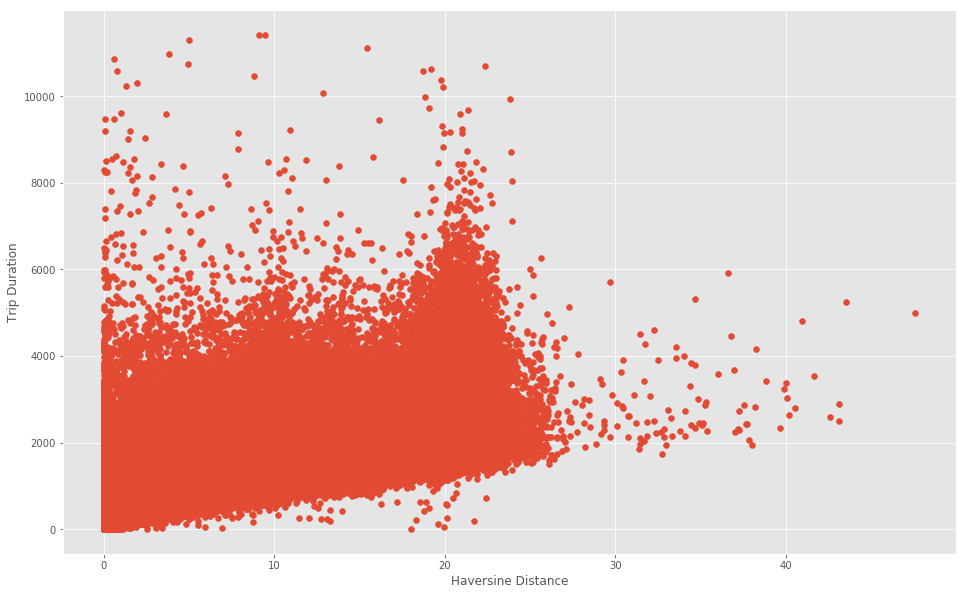

In [24]:
plt.figure()
plt.scatter(train['distance_haversine'].values,train['trip_duration'].values)
plt.xlabel("Haversine Distance")
plt.ylabel("Trip Duration")
plt.show()

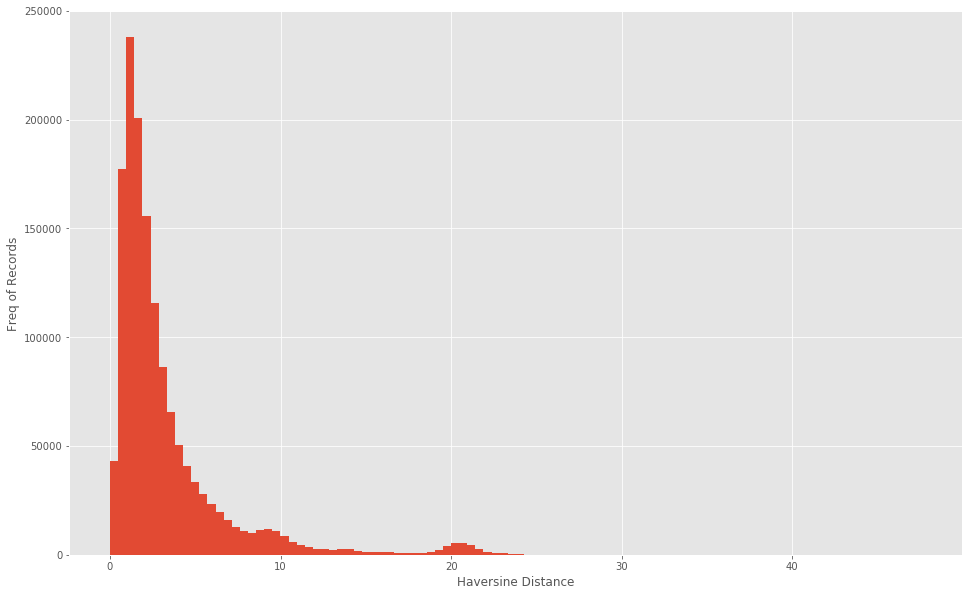

In [25]:
plt.figure()
plt.hist(train['distance_haversine'].values,bins=100)
plt.xlabel("Haversine Distance")
plt.ylabel("Freq of Records")
plt.show()

In [26]:
test.loc[:,'distance_haversine'] = haversine_array(test['pickup_latitude'].values,test['pickup_longitude'].values,test['dropoff_latitude'].values,test['dropoff_longitude'].values)
train.loc[:,'distance_dummy_manhattan'] = dummy_manhattan(train['pickup_latitude'].values,train['pickup_longitude'].values,train['dropoff_latitude'].values,train['dropoff_longitude'].values)
test.loc[:,'distance_dummy_manhattan'] = dummy_manhattan(test['pickup_latitude'].values,test['pickup_longitude'].values,test['dropoff_latitude'].values,test['dropoff_longitude'].values)
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

In [27]:
coords = np.vstack((train[['pickup_latitude','pickup_longitude']].values,train[['dropoff_latitude','dropoff_longitude']].values))

In [28]:
sample_ind = np.random.permutation(len(coords))[:500000]
from sklearn.cluster import MiniBatchKMeans

In [29]:
kmeans = MiniBatchKMeans(n_clusters = 100, batch_size=10000).fit(coords[sample_ind])

In [30]:
train.loc[:,'pickup_cluster'] = kmeans.predict(train[['pickup_latitude','pickup_longitude']])
test.loc[:,'pickup_cluster'] = kmeans.predict(test[['pickup_latitude','pickup_longitude']])
train.loc[:,'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude','dropoff_longitude']])
test.loc[:,'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude','dropoff_longitude']])

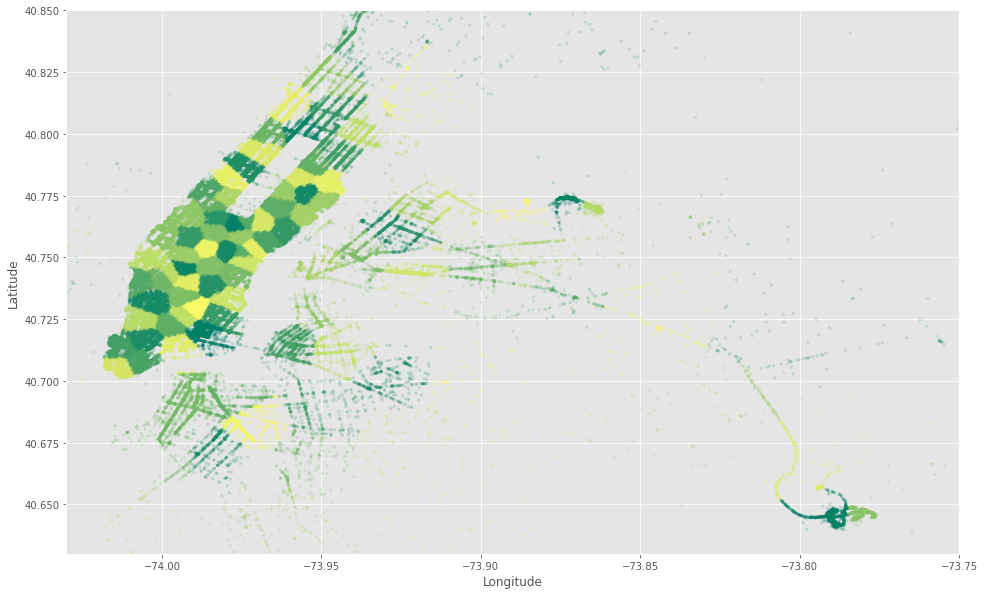

In [31]:
plt.figure()
plt.scatter(train.pickup_longitude.values[:500000],train.pickup_latitude.values[:500000],s=10,lw=0,cmap='summer',c=train.pickup_cluster[:500000].values,alpha=0.2)
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [32]:
train['Month'] = train.pickup_datetime.dt.month
test['Month'] = test.pickup_datetime.dt.month

In [33]:
train['Dayofmonth'] = train.pickup_datetime.dt.day
test['Dayofmonth'] = test.pickup_datetime.dt.day

In [34]:
train['Hour'] = train.pickup_datetime.dt.hour
test['Hour'] = test.pickup_datetime.dt.hour

In [35]:
train['Dayofweek'] = train.pickup_datetime.dt.dayofweek
test['Dayofweek'] = test.pickup_datetime.dt.dayofweek

In [124]:
train.loc[:,'avg_speed_h'] = (train['distance_haversine']/train['trip_duration']) * 1000
train.loc[:,'avg_speed_m'] = (train['distance_dummy_manhattan']/train['trip_duration'])* 1000

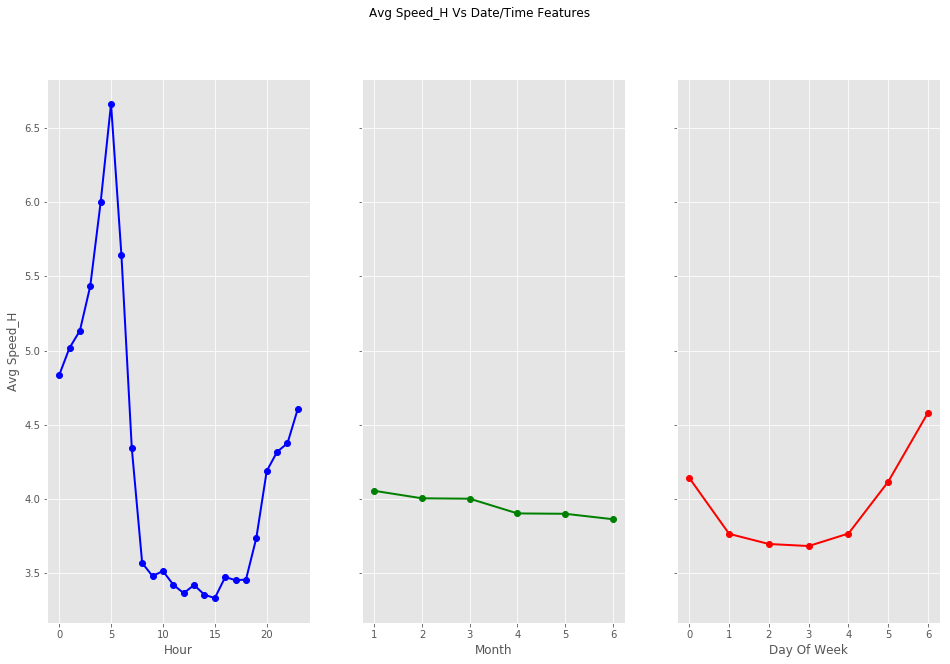

In [37]:
fig,ax = plt.subplots(ncols=3,sharey = True)
ax[0].plot(train.groupby('Hour').mean()['avg_speed_h'], 'bo-',lw=2)
ax[1].plot(train.groupby('Month').mean()['avg_speed_h'], 'go-',lw=2)
ax[2].plot(train.groupby('Dayofweek').mean()['avg_speed_h'], 'ro-',lw=2)
ax[0].set_ylabel('Avg Speed_H')
ax[0].set_xlabel('Hour')
ax[1].set_xlabel('Month')
ax[2].set_xlabel('Day Of Week')
fig.suptitle("Avg Speed_H Vs Date/Time Features")
plt.show()

In [38]:
coord_speed = train.groupby(['pickup_latitude','pickup_longitude'])['avg_speed_h'].mean().reset_index()

In [39]:
coord_count = train.groupby(['pickup_latitude','pickup_longitude'])['id'].count().reset_index()

In [40]:
coord_stats = pd.merge(coord_speed,coord_count,on=['pickup_latitude','pickup_longitude'])

In [44]:
coord_stats.head()

,pickup_latitude,pickup_longitude,avg_speed_h,id
0,40.630,-73.895,4.848,1
1,40.630,-73.723,0.013,1
2,40.630,-73.921,4.095,1
3,40.631,-73.972,9.666,1
4,40.631,-74.009,13.697,1


In [49]:
coord_stats_v = coord_stats[coord_stats['id']>100]

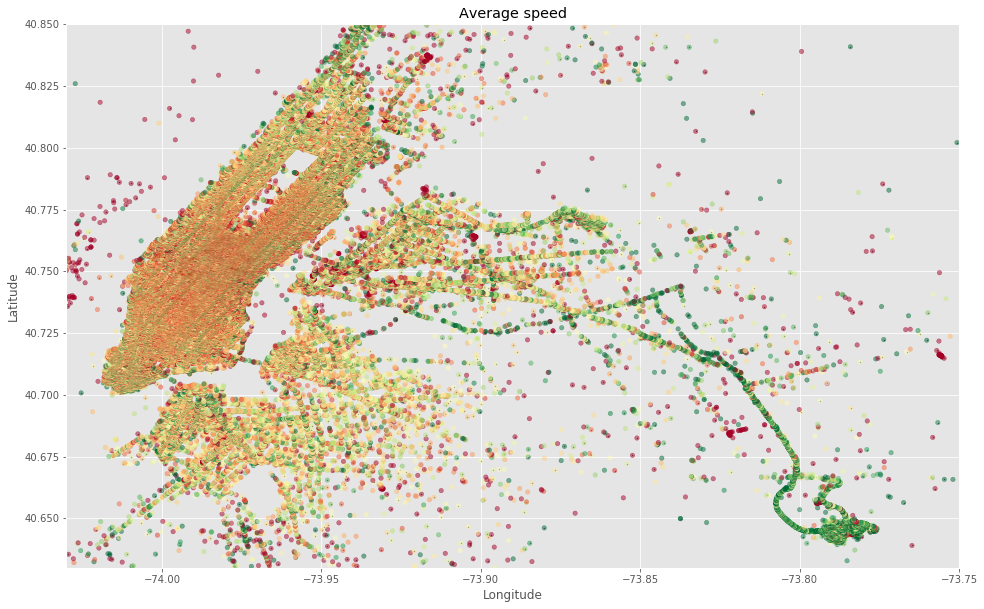

In [55]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_longitude.values, coord_stats.pickup_latitude.values, c=coord_stats.avg_speed_h.values,cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

In [56]:
train.loc[:, 'pickup_lat_bin'] =np.round(train['pickup_latitude'],3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'],3)

In [57]:
gby_cols = ['pickup_lat_bin','pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed,coord_count,on=gby_cols)

In [99]:
coord_stats = coord_stats[coord_stats['id']>100]
coord_stats.describe()

,pickup_lat_bin,pickup_long_bin,avg_speed_h,id
count,2304.000,2304.000,2304.000,2304.000
mean,40.751,-73.978,3.911,580.637
std,0.028,0.030,0.730,613.258
min,40.641,-74.017,0.639,101.000
25%,40.733,-73.994,3.488,209.750
50%,40.753,-73.982,3.792,401.000
75%,40.770,-73.968,4.176,777.000
max,40.834,-73.777,16.911,8622.000


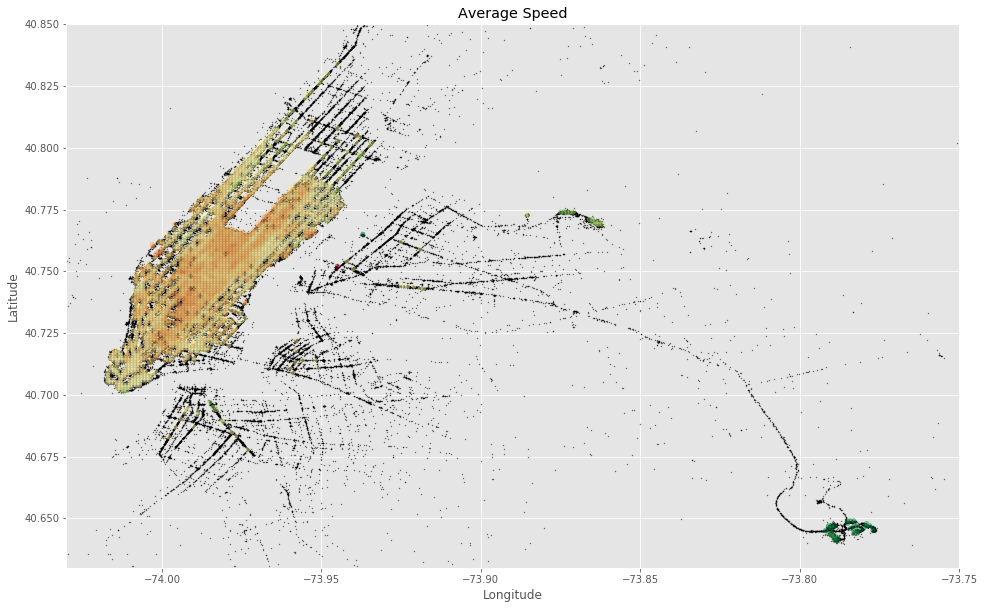

In [111]:
fig, ax = plt.subplots(ncols=1,nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], color='black', alpha=0.4,s=1)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values, cmap="RdYlGn", c=coord_stats.avg_speed_h, vmin=1,vmax=8, alpha=0.5,s=20)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.title("Average Speed")
plt.show()

In [112]:
#using extra dataset that is obtained by OSRM in this link - https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm/data

fr1 = pd.read_csv("fastest_routes_train_part_1.csv", usecols=['id','total_distance','total_travel_time','number_of_steps'])
fr2 = pd.read_csv("fastest_routes_train_part_2.csv", usecols=['id','total_distance','total_travel_time','number_of_steps'])

test_street_info = pd.read_csv("fastest_routes_test.csv", usecols=['id','total_distance','total_travel_time','number_of_steps'])


In [115]:
train_street_info = pd.concat((fr1,fr2))

In [116]:
train = train.merge(train_street_info, how='left',on='id')
test = test.merge(test_street_info, how='left',on='id')

In [123]:
train.shape

(1438576, 29)

In [130]:
test.shape

(625134, 22)

In [131]:
train.to_csv("train_mod.csv",index = False)
test.to_csv("test_mod.csv",index = False)

In [1]:
'''
NEW DAY no operation above will be valid below thats y i saved the train and test to csv earlier.
Only imports were run at the start and then directly the below is run.
'''

'\n\n'

In [3]:
train = pd.read_csv("train_mod.csv")
test = pd.read_csv("test_mod.csv")

In [35]:
train1 = pd.read_csv("train_mod.csv")
test1 = pd.read_csv("test_mod.csv")

In [4]:
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')

In [5]:
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(train['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_pickup_test = pd.get_dummies(test['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(train['dropoff_cluster'], prefix='d', prefix_sep='_')
cluster_dropoff_test = pd.get_dummies(test['dropoff_cluster'], prefix='d', prefix_sep='_')
month_train = pd.get_dummies(train['Month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['Month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['Dayofmonth'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['Dayofmonth'], prefix='dom', prefix_sep='_')
dow_train = pd.get_dummies(train['Dayofweek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test['Dayofweek'], prefix='dow', prefix_sep='_')
hour_train = pd.get_dummies(train['Hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['Hour'], prefix='h', prefix_sep='_')

In [42]:
#pd.set_option('display.float_format', lambda x: '%.3f' % x)
#passenger_count_test.describe()
#passenger_count_test = passenger_count_test.drop('pc_9',axis=1)
passenger_count_train.describe()
passenger_count_train = passenger_count_train.drop(['pc_9','pc_7'],axis=1)

In [36]:
train1 = train1.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','Dayofmonth','Hour','Dayofweek','pickup_longitude','pickup_latitude','dropoff_latitude','dropoff_longitude','dropoff_datetime','avg_speed_h','avg_speed_m','pickup_lat_bin','pickup_long_bin','trip_duration'],axis=1)
Test_id = test1['id']
test1 = test1.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','Dayofmonth','Dayofweek','Hour','pickup_latitude','pickup_longitude','dropoff_longitude','dropoff_latitude'],axis=1)

In [37]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438576 entries, 0 to 1438575
Data columns (total 11 columns):
pickup_datetime             1438576 non-null object
pickup_date                 1438576 non-null object
log_trip_duration           1438576 non-null float64
distance_haversine          1438576 non-null float64
distance_dummy_manhattan    1438576 non-null float64
direction                   1438576 non-null float64
pickup_cluster              1438576 non-null int64
dropoff_cluster             1438576 non-null int64
total_distance              1438575 non-null float64
total_travel_time           1438575 non-null float64
number_of_steps             1438575 non-null float64
dtypes: float64(7), int64(2), object(2)
memory usage: 120.7+ MB


In [38]:
Train_master_v1 = pd.concat([train1, vendor_train, passenger_count_train, store_and_fwd_flag_train, cluster_dropoff_train, cluster_pickup_train, month_train, hour_train, dom_train, dow_train],axis=1)
Test_master_v1 = pd.concat([test1, vendor_test, passenger_count_test, store_and_fwd_flag_test, cluster_dropoff_test, cluster_pickup_test, month_test, hour_test, dom_test, dow_test],axis=1)

In [43]:
Train_master_v1.shape, Test_master_v1.shape
Train_master_v1 = Train_master_v1.drop(['pc_7','pc_9'],axis=1)
Train_master_v1.shape, Test_master_v1.shape

((1438576, 290), (625134, 289))

In [44]:
Train_master_v1 = Train_master_v1.drop(['pickup_datetime', 'pickup_date'],axis=1)
Test_master_v1 = Test_master_v1.drop(['pickup_datetime', 'pickup_date'],axis=1)

In [45]:
Train_master_v1.shape, Test_master_v1.shape

((1438576, 288), (625134, 287))

In [30]:
Test_master_v1.describe()

,distance_haversine,distance_dummy_manhattan,direction,pickup_cluster,dropoff_cluster,total_distance,total_travel_time,number_of_steps,vi_1,vi_2,...,dom_29,dom_30,dom_31,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
count,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,...,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000,625134.000000
mean,3.433411,4.434435,-15.574764,46.596469,47.421447,4616.899919,388.926100,7.545392,0.465116,0.534884,...,0.031728,0.026545,0.015857,0.128593,0.139679,0.143790,0.149504,0.153983,0.150739,0.133712
std,4.272238,5.694935,104.459126,28.637165,28.242539,5279.273407,313.726758,4.435818,0.498782,0.498782,...,0.175274,0.160749,0.124924,0.334749,0.346654,0.350877,0.356585,0.360933,0.357794,0.340343
min,0.000000,0.000000,-179.995569,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.231929,1.571122,-124.943348,21.000000,22.000000,1665.400000,181.500000,5.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.093738,2.688337,8.248382,49.000000,49.000000,2754.650000,289.300000,6.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.882561,5.005596,53.439931,70.000000,71.000000,5116.300000,490.600000,9.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1036.043469,1448.117358,180.000000,99.000000,99.000000,91521.700000,4578.100000,50.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
Train_master_v1.describe()

,log_trip_duration,distance_haversine,distance_dummy_manhattan,direction,pickup_cluster,dropoff_cluster,total_distance,total_travel_time,number_of_steps,vi_1,...,dom_29,dom_30,dom_31,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
count,1.438576e+06,1.438576e+06,1.438576e+06,1.438576e+06,1.438576e+06,1.438576e+06,1.438575e+06,1.438575e+06,1.438575e+06,1.438576e+06,...,1.438576e+06,1.438576e+06,1.438576e+06,1.438576e+06,1.438576e+06,1.438576e+06,1.438576e+06,1.438576e+06,1.438576e+06,1.438576e+06
mean,6.447953e+00,3.304182e+00,4.273157e+00,-1.558644e+01,4.659491e+01,4.744404e+01,4.454476e+03,3.812284e+02,7.451424e+00,4.656800e-01,...,3.210814e-02,2.682722e-02,1.576072e-02,1.286189e-01,1.391390e-01,1.442253e-01,1.498517e-01,1.532439e-01,1.513518e-01,1.335696e-01
std,7.713237e-01,3.688813e+00,4.928779e+00,1.046197e+02,2.864725e+01,2.828183e+01,4.981266e+03,3.019446e+02,4.323674e+00,4.988209e-01,...,1.762873e-01,1.615783e-01,1.245485e-01,3.347777e-01,3.460916e-01,3.513181e-01,3.569261e-01,3.602226e-01,3.583915e-01,3.401894e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.799918e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.976351e+00,1.225055e+00,1.562306e+00,-1.258071e+02,2.100000e+01,2.200000e+01,1.657100e+03,1.806000e+02,4.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.484635e+00,2.070081e+00,2.658587e+00,8.166721e+00,4.900000e+01,4.900000e+01,2.725600e+03,2.868000e+02,6.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,6.964136e+00,3.775363e+00,4.872514e+00,5.401495e+01,7.000000e+01,7.200000e+01,4.974250e+03,4.810000e+02,9.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,9.342333e+00,4.758123e+01,5.519491e+01,1.800000e+02,9.900000e+01,9.900000e+01,5.728970e+04,2.954300e+03,3.900000e+01,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [12]:
from sklearn.model_selection import train_test_split

In [46]:
Train, Test = train_test_split(Train_master_v1[:100000], test_size=0.2)

In [47]:
X_train = Train.drop(['log_trip_duration'],axis=1)
Y_train = Train['log_trip_duration']
X_test = Test.drop(['log_trip_duration'],axis=1)
Y_test = Test['log_trip_duration']

In [48]:
Y_test = Y_test.reset_index().drop('index',axis=1)
Y_train = Y_train.reset_index().drop('index',axis=1)

In [50]:
#MODEL FFS NOW - 

dtrain = xgb.DMatrix(X_train,label = Y_train)
dvalid = xgb.DMatrix(X_test, label = Y_test)
dtest = xgb.DMatrix(Test_master_v1)
watchlist = [(dtrain,'train'),(dvalid,'valid')]

In [51]:
md = [6]
lr = [0.1,0.3]
mcw = [20,25,30]
for m in md:
    for l in lr:
        for n in mcw:
            t0 = datetime.now()
            xgb_pars = {'min_child_weight':n, 'eta':l, 'colsample_bytree':0.9, 'max_depth':m, 'subsample': 0.9, 'lambda':1, 'nthread': -1, 'booster': 'gbtree', 'silent':1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
            model =  xgb.train(xgb_pars, dtrain, 50, watchlist, early_stopping_rounds=10, maximize=False, verbose_eval=1)

[0]	train-rmse:5.40152	valid-rmse:5.39611
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:4.86553	valid-rmse:4.86019
[2]	train-rmse:4.38327	valid-rmse:4.37816
[3]	train-rmse:3.94978	valid-rmse:3.94476
[4]	train-rmse:3.56008	valid-rmse:3.55532
[5]	train-rmse:3.20979	valid-rmse:3.20508
[6]	train-rmse:2.89509	valid-rmse:2.89047
[7]	train-rmse:2.6126	valid-rmse:2.60813
[8]	train-rmse:2.35891	valid-rmse:2.35457
[9]	train-rmse:2.13132	valid-rmse:2.12709
[10]	train-rmse:1.92721	valid-rmse:1.92307
[11]	train-rmse:1.74444	valid-rmse:1.74031
[12]	train-rmse:1.58098	valid-rmse:1.57699
[13]	train-rmse:1.43493	valid-rmse:1.43107
[14]	train-rmse:1.30443	valid-rmse:1.30065
[15]	train-rmse:1.18822	valid-rmse:1.18454
[16]	train-rmse:1.08499	valid-rmse:1.08139
[17]	train-rmse:0.993362	valid-rmse:0.9899
[18]	train-rmse:0.912217	valid-rmse:0.908725
[19]	train-rmse:0.840745	valid-rmse:0.837341
[2

[24]	train-rmse:0.377452	valid-rmse:0.383668
[25]	train-rmse:0.375604	valid-rmse:0.382553
[26]	train-rmse:0.374178	valid-rmse:0.381429
[27]	train-rmse:0.372695	valid-rmse:0.380544
[28]	train-rmse:0.371773	valid-rmse:0.380081
[29]	train-rmse:0.370884	valid-rmse:0.379837
[30]	train-rmse:0.370191	valid-rmse:0.3793
[31]	train-rmse:0.369032	valid-rmse:0.378659
[32]	train-rmse:0.367775	valid-rmse:0.377736
[33]	train-rmse:0.366389	valid-rmse:0.376781
[34]	train-rmse:0.365399	valid-rmse:0.376168
[35]	train-rmse:0.364682	valid-rmse:0.37575
[36]	train-rmse:0.36376	valid-rmse:0.375134
[37]	train-rmse:0.363	valid-rmse:0.374702
[38]	train-rmse:0.36241	valid-rmse:0.374255
[39]	train-rmse:0.361476	valid-rmse:0.37449
[40]	train-rmse:0.360496	valid-rmse:0.374368
[41]	train-rmse:0.359222	valid-rmse:0.37359
[42]	train-rmse:0.358568	valid-rmse:0.373476
[43]	train-rmse:0.357709	valid-rmse:0.373102
[44]	train-rmse:0.356997	valid-rmse:0.372558
[45]	train-rmse:0.356273	valid-rmse:0.372056
[46]	train-rmse:0.35

In [52]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.5, 'colsample_bytree': 0.9, 'max_depth': 6,'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 10, watchlist, early_stopping_rounds=2,maximize=False, verbose_eval=1)
print('Modeling RMSE %.5f' % model.best_score)

[0]	train-rmse:3.02406	valid-rmse:3.02014
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:1.55934	valid-rmse:1.55666
[2]	train-rmse:0.86136	valid-rmse:0.860222
[3]	train-rmse:0.562011	valid-rmse:0.563244
[4]	train-rmse:0.452832	valid-rmse:0.455889
[5]	train-rmse:0.41673	valid-rmse:0.420857
[6]	train-rmse:0.402163	valid-rmse:0.408054
[7]	train-rmse:0.394608	valid-rmse:0.402135
[8]	train-rmse:0.389552	valid-rmse:0.398721
[9]	train-rmse:0.385367	valid-rmse:0.395845
Modeling RMSE 0.39585


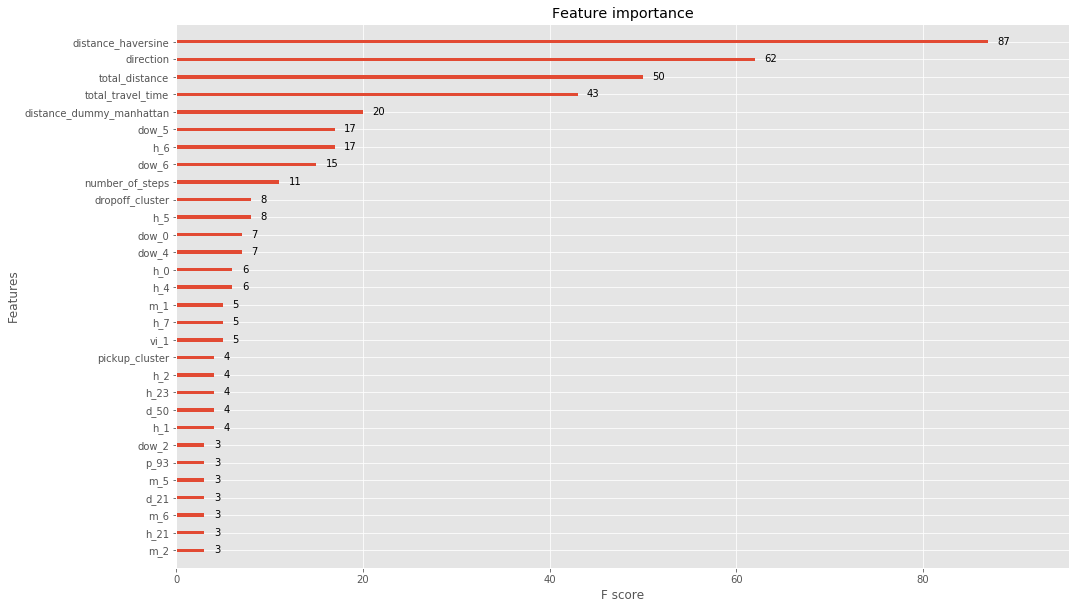

In [53]:
xgb.plot_importance(model, max_num_features=30)

In [77]:
pred = model.predict(dtest)

In [78]:
pred = np.exp(pred)

In [79]:
submission = pd.concat([Test_id,pd.DataFrame(pred)],axis=1)

In [81]:
submission.columns = ['id','trip_duration']

In [83]:
submission['trip_duration'] = submission.apply(lambda x: 1 if (x['trip_duration'] <=0) else x['trip_duration'],axis=1)

In [84]:
submission.to_csv('submission.csv',index=False)

In [86]:
pred1 = model.predict(dtest)
pred1 = np.exp(pred1)-1
submission1 = pd.concat([Test_id, pd.DataFrame(pred1)],axis=1)
submission1.columns = ['id','trip_duration']
submission1['trip_duration'] = submission1.apply(lambda x:1 if (x['trip_duration'] <=0 ) else x['trip_duration'],axis=1)
submission1.to_csv('submission1.csv',index=False)